In [1]:
# !pip install gputil

# Import Libraries and Constant

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import UnidentifiedImageError, ImageFile, Image
import random
import time
import psutil
# import GPUtil

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
DATA_DIR_X = 'latent_rep/final_dataset_baru.npy'
DATA_DIR_Y = 'Plots'

# All The Functions

In [4]:
def load_data_x(data_dir):
  X = np.load(data_dir)
  print("X shape:", X.shape)
  return X

In [5]:
def load_data_y(img_dir, target_size=(128, 128)):
    data_list = []
    files = sorted(os.listdir(img_dir))

    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            path = os.path.join(img_dir, f)
            try:
                with Image.open(path) as img:
                    img = img.convert('RGB')
                    img = img.resize(target_size)
                    arr = np.array(img, dtype=np.float32) / 255.0
                    data_list.append(arr)
            except (OSError, UnidentifiedImageError) as e:
                print(f"⚠️ Skipping corrupted or unreadable file: {path} ({e})")

    if len(data_list) == 0:
        print("⚠️ No valid images found in:", img_dir)
        return np.empty((0, *target_size, 3), dtype=np.float32)

    Y = np.array(data_list)
    print("✅ Y shape:", Y.shape)
    return Y

In [6]:
class PermittivityANN(nn.Module):
  def __init__(self, input_dim=1152, output_dim=12288):
    super(PermittivityANN, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(input_dim, 2048),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(2048, 4096),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    return self.model(x)

In [7]:
def train_with_metrics(net, train_loader, val_loader, criterion, optimizer, epochs, device="cpu"):
    history = {
        "train_loss": [],
        "val_loss": [],
        "epoch_time": [],
        "grad_norm": [],
        "memory_usage": [],
    }

    net.to(device)
    for epoch in range(epochs):
        net.train()
        start_time = time.time()
        running_loss = 0.0

        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()

            # 🔹 Gradient norm
            total_norm = 0.0
            for p in net.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2).item()
                    total_norm += param_norm ** 2
            total_norm = total_norm ** 0.5

            optimizer.step()
            running_loss += loss.item()

        # Training loss
        train_loss = running_loss / len(train_loader)
        history["train_loss"].append(train_loss)

        # Validation loss
        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            for val_X, val_Y in val_loader:
                val_X, val_Y = val_X.to(device), val_Y.to(device)
                preds = net(val_X)
                v_loss = criterion(preds, val_Y)
                val_loss += v_loss.item()
            val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)

        # Time per epoch
        epoch_time = time.time() - start_time
        history["epoch_time"].append(epoch_time)

        # Gradient stability
        history["grad_norm"].append(total_norm)

        # Memory usage (GPU or CPU)
        if device == "cuda":
            mem_used = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
        else:
            mem_used = psutil.virtual_memory().percent
        history["memory_usage"].append(mem_used)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
              f"Time: {epoch_time:.2f}s | GradNorm: {total_norm:.2f} | Mem: {mem_used:.1f}")

    return history

In [8]:
def plot_metrics(history):
    plt.figure(figsize=(15,10))

    # Loss convergence
    plt.subplot(2,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Training time per epoch
    plt.subplot(2,2,2)
    plt.plot(history["epoch_time"], marker="o")
    plt.title("Training Time per Epoch (s)")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")

    # Gradient norm stability
    plt.subplot(2,2,3)
    plt.plot(history["grad_norm"], marker="x")
    plt.title("Gradient Norm per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("L2 Norm")

    # Memory footprint
    plt.subplot(2,2,4)
    plt.plot(history["memory_usage"], marker="s")
    plt.title("Memory Usage")
    plt.xlabel("Epoch")
    plt.ylabel("% Used (CPU) / MB (GPU)")

    plt.tight_layout()
    plt.show()

In [9]:
def plot_random_results(net, X, Y, num_samples=5, map_shape=(128, 128, 3)):
    device = next(net.parameters()).device
    net.eval()

    with torch.no_grad():
        X_tensor = torch.from_numpy(X).float().to(device)
        X_tensor = X_tensor.view(X_tensor.size(0), -1)
        preds = net(X_tensor)
        preds_maps = preds.view(-1, *map_shape)

    indices = random.sample(range(len(preds_maps)), num_samples)

    fig, axes = plt.subplots(3, num_samples, figsize=(4 * num_samples, 10))

    for col, idx in enumerate(indices):
        sample_pred = preds_maps[idx].cpu().numpy()
        sample_real = Y[idx].reshape(*map_shape)
        diff = np.abs(sample_real - sample_pred)


        axes[0, col].imshow(sample_pred, cmap='viridis')
        axes[0, col].set_title('Prediction', fontsize=16)
        axes[0, col].axis('off')


        axes[1, col].imshow(sample_real)
        axes[1, col].set_title('Ground Truth', fontsize=16)
        axes[1, col].axis('off')


        im = axes[2, col].imshow(diff, cmap='hot')
        axes[2, col].set_title('Difference', fontsize=16)
        axes[2, col].axis('off')


    fig.subplots_adjust(right=0.9, hspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.suptitle('Predictions and Ground Truth with Multilayer Perceptron', fontsize=20, fontweight='bold')

    plt.show()

# Implementation

In [10]:
X = load_data_x(DATA_DIR_X)
Y = load_data_y(DATA_DIR_Y, target_size=(128,128))

X shape: (715, 24, 24, 2)
✅ Y shape: (715, 128, 128, 3)


In [11]:
Y_flat = Y.reshape(Y.shape[0], -1)
print('Y flat shape:', Y_flat.shape)

Y flat shape: (715, 49152)


In [12]:
X_tensor = torch.tensor(X, dtype=torch.float32).view(X.shape[0], -1)
Y_tensor = torch.tensor(Y, dtype=torch.float32).view(Y.shape[0], -1)
dataset = TensorDataset(X_tensor, Y_tensor)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [13]:
net = PermittivityANN(input_dim=1152, output_dim=49152)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [14]:
epochs = 30

Epoch 1/30 | Train Loss: 0.054359 | Val Loss: 0.028859 | Time: 8.33s | GradNorm: 0.31 | Mem: 3259.7
Epoch 2/30 | Train Loss: 0.030895 | Val Loss: 0.027481 | Time: 7.19s | GradNorm: 0.26 | Mem: 3259.2
Epoch 3/30 | Train Loss: 0.030320 | Val Loss: 0.027547 | Time: 7.29s | GradNorm: 0.11 | Mem: 3259.7
Epoch 4/30 | Train Loss: 0.028960 | Val Loss: 0.026516 | Time: 7.26s | GradNorm: 0.14 | Mem: 3259.2
Epoch 5/30 | Train Loss: 0.028646 | Val Loss: 0.026138 | Time: 7.15s | GradNorm: 0.40 | Mem: 3259.7
Epoch 6/30 | Train Loss: 0.027787 | Val Loss: 0.025899 | Time: 7.14s | GradNorm: 0.08 | Mem: 3259.2
Epoch 7/30 | Train Loss: 0.027442 | Val Loss: 0.027363 | Time: 7.15s | GradNorm: 0.15 | Mem: 3259.7
Epoch 8/30 | Train Loss: 0.027220 | Val Loss: 0.026946 | Time: 7.15s | GradNorm: 0.15 | Mem: 3259.2
Epoch 9/30 | Train Loss: 0.027269 | Val Loss: 0.026034 | Time: 7.14s | GradNorm: 0.28 | Mem: 3259.7
Epoch 10/30 | Train Loss: 0.026763 | Val Loss: 0.026832 | Time: 7.14s | GradNorm: 0.14 | Mem: 3259.2

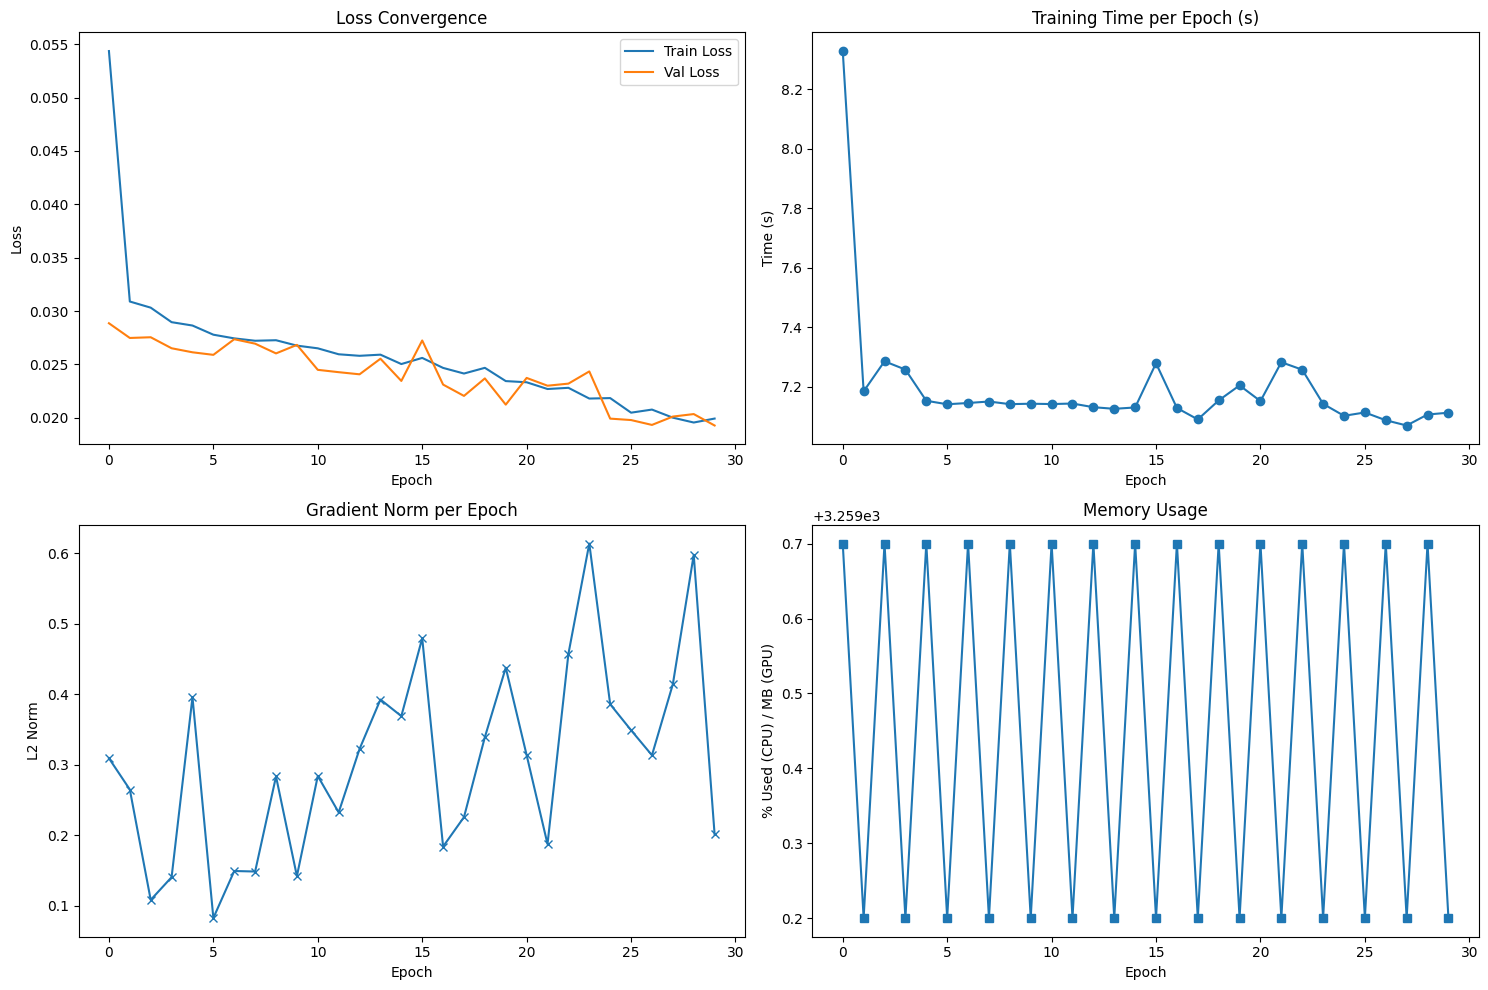

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
history = train_with_metrics(net, train_loader, val_loader, criterion, optimizer, epochs, device=device)
plot_metrics(history)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030355267..1.0400429].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041696228..0.8963564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08154664..0.96414006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0046478556..0.90263975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008821603..0.9124948].


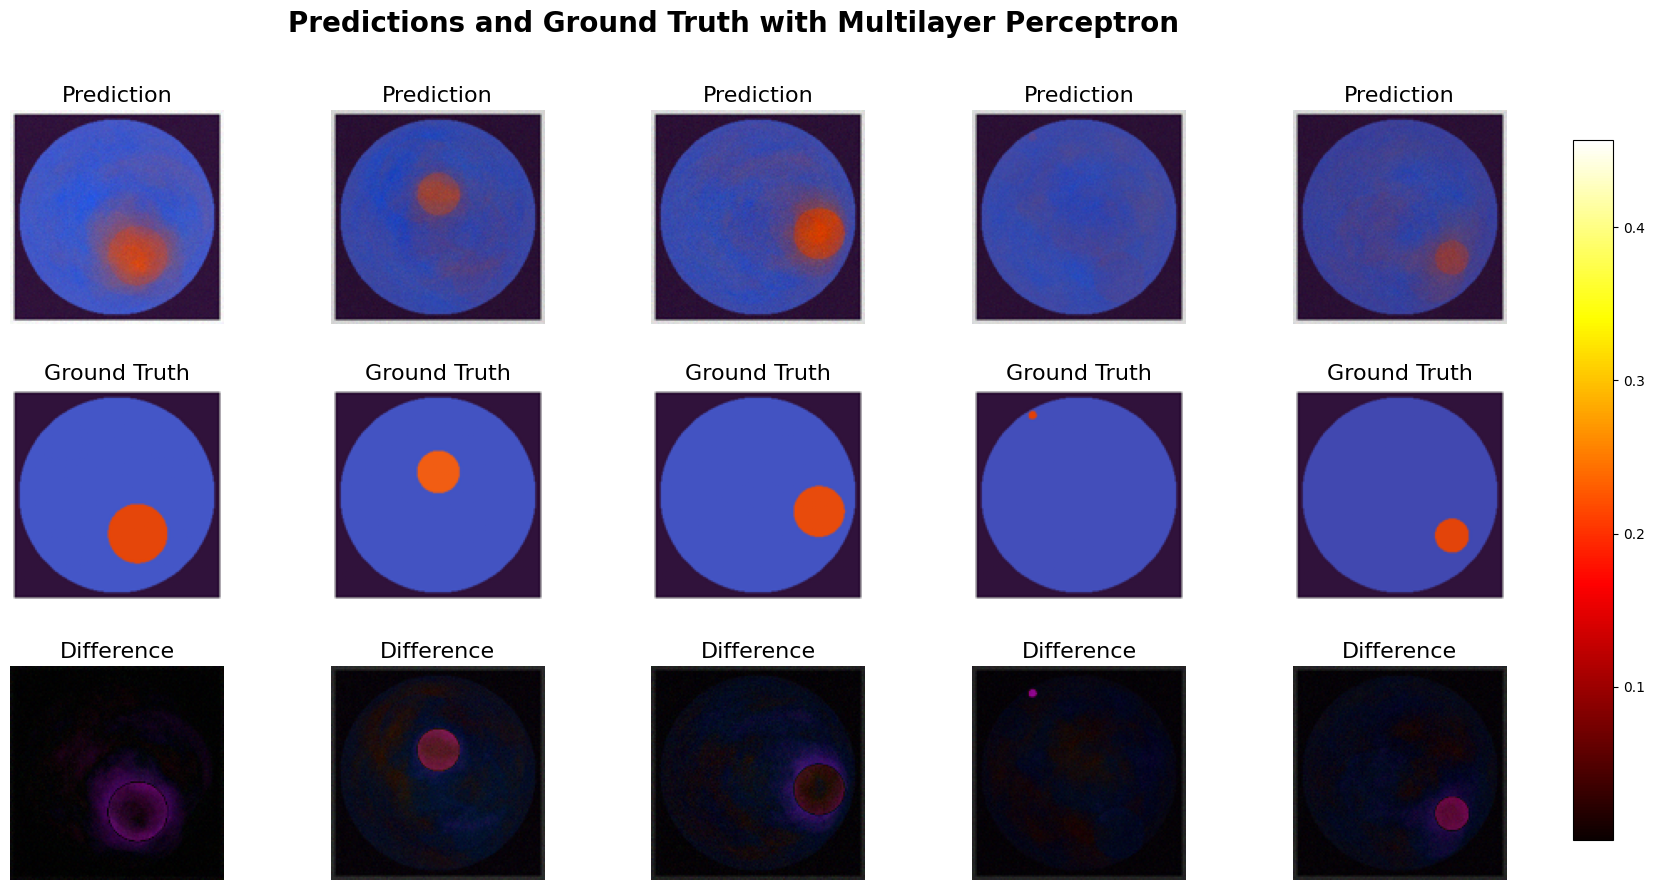

In [ ]:
plot_random_results(net, X, Y, num_samples=5, map_shape=(128,128,3))